/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Explaining: 'I really didn't enjoy this movie, it was boring and too long.'

Concept Relevance Scores:
positive_sentiment: 0.9064
negative_sentiment: 0.9004
casual_language: 0.8519
technical_language: 0.7948


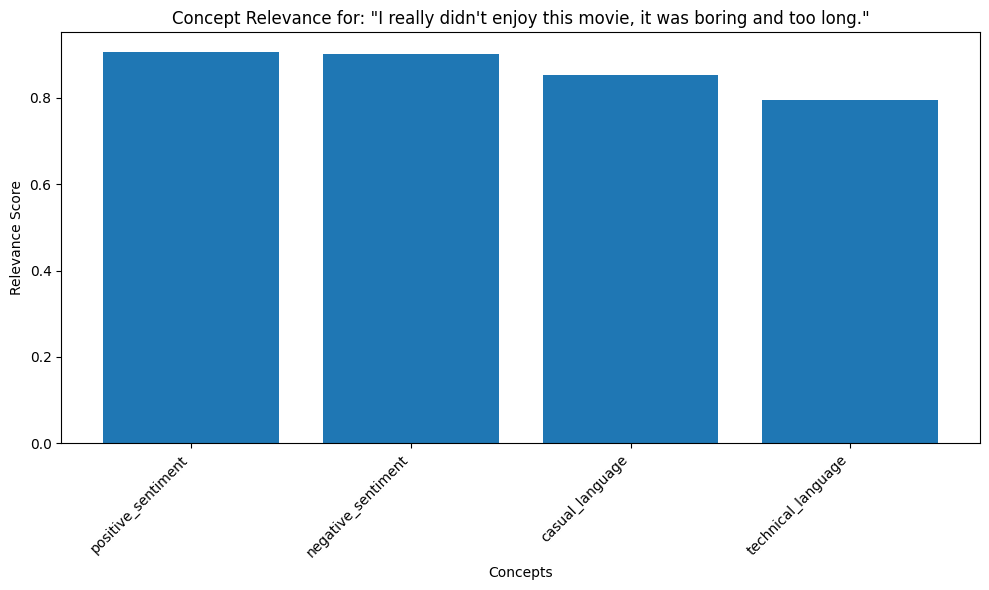

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

class ConceptBasedExplainer:
    def __init__(self, model, tokenizer, concept_examples):
        """
        Initialize the concept-based explainer.

        Args:
            model: A pre-trained language model
            tokenizer: The tokenizer for the model
            concept_examples: Dictionary mapping concept names to lists of example texts
        """
        self.model = model
        self.tokenizer = tokenizer
        self.concept_vectors = {}
        self.concept_examples = concept_examples

        # Extract concept vectors
        for concept, examples in concept_examples.items():
            self.concept_vectors[concept] = self._extract_concept_vector(examples)

    def _extract_concept_vector(self, examples):
        """
        Extract a concept vector by averaging embeddings of example texts.
        """
        embeddings = []
        for text in examples:
            # Tokenize and get model embeddings
            inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            with torch.no_grad():
                outputs = self.model(**inputs)
                # Use the [CLS] token embedding as the sentence representation
                embedding = outputs.last_hidden_state[:, 0, :].numpy()
                embeddings.append(embedding[0])

        # Average the embeddings to get the concept vector
        return np.mean(embeddings, axis=0)

    def explain_prediction(self, text):
        """
        Explain a prediction by showing concept relevance scores.
        """
        # Get text embedding
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
            text_embedding = outputs.last_hidden_state[:, 0, :].numpy()[0]

        # Calculate similarity to each concept
        concept_scores = {}
        for concept, concept_vector in self.concept_vectors.items():
            similarity = cosine_similarity([text_embedding], [concept_vector])[0][0]
            concept_scores[concept] = similarity

        return concept_scores

    def visualize_explanation(self, text):
        """
        Visualize the concept relevance for a given text.
        """
        concept_scores = self.explain_prediction(text)

        # Sort concepts by relevance
        sorted_concepts = sorted(concept_scores.items(), key=lambda x: x[1], reverse=True)
        concepts = [c[0] for c in sorted_concepts]
        scores = [c[1] for c in sorted_concepts]

        # Create bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(concepts, scores)
        plt.xlabel('Concepts')
        plt.ylabel('Relevance Score')
        plt.title(f'Concept Relevance for: "{text}"')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('concept_explanation.png')
        plt.show()

        return sorted_concepts

# Example usage
def concept_based_explanation_example():
    # Load pre-trained model and tokenizer
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Define concepts with example texts
    concept_examples = {
        "positive_sentiment": [
            "I love this product, it's amazing!",
            "The experience was wonderful and exceeded my expectations.",
            "This is the best movie I've seen all year."
        ],
        "negative_sentiment": [
            "This was a terrible experience, I'm very disappointed.",
            "The product broke after one use, waste of money.",
            "I hated every minute of this awful movie."
        ],
        "technical_language": [
            "The API uses REST principles with JSON payloads.",
            "We implemented a transformer architecture with multi-head attention.",
            "The database schema includes foreign key constraints for referential integrity."
        ],
        "casual_language": [
            "Hey, what's up? How's it going?",
            "Just chilling and watching some Netflix tonight.",
            "OMG that's so cool! Can't wait to try it!"
        ]
    }

    # Initialize the explainer
    explainer = ConceptBasedExplainer(model, tokenizer, concept_examples)

    # Text to explain
    text_to_explain = "I really didn't enjoy this movie, it was boring and too long."

    # Get and print explanation
    print(f"Explaining: '{text_to_explain}'")
    concept_scores = explainer.explain_prediction(text_to_explain)

    print("\nConcept Relevance Scores:")
    for concept, score in sorted(concept_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{concept}: {score:.4f}")

    # Visualize explanation
    explainer.visualize_explanation(text_to_explain)

if __name__ == "__main__":
    concept_based_explanation_example()

Loaded pretrained model gpt2-small into HookedTransformer
Tracing Mechanistic Behavior for: 'I really didn't enjoy this movie, it was boring and too long.'


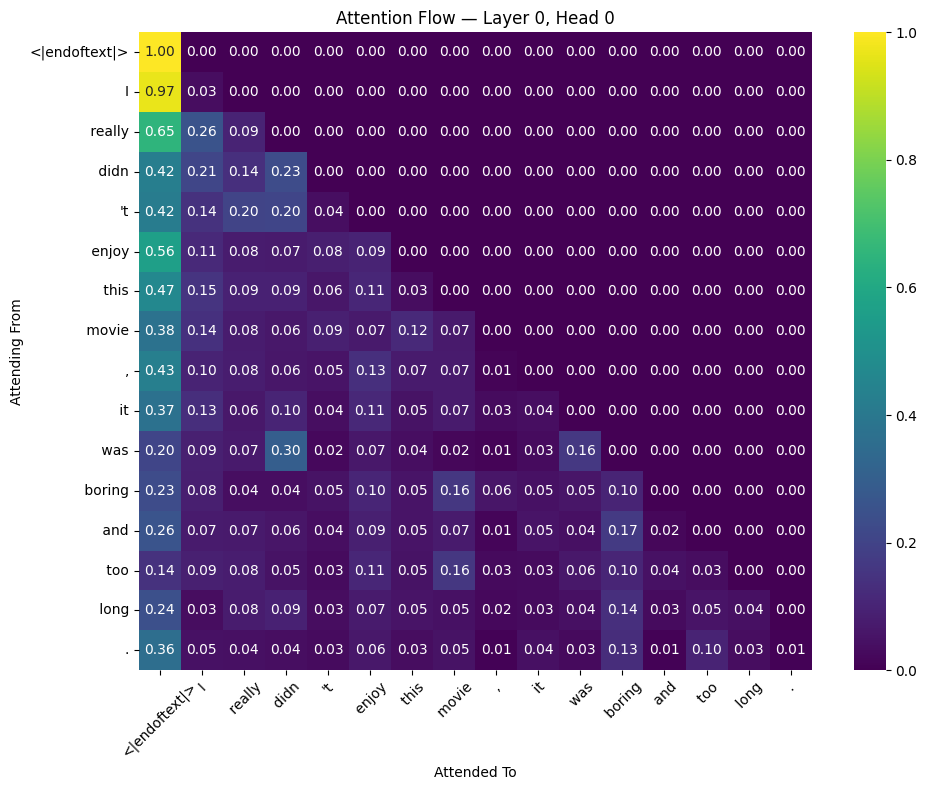

In [10]:
# ================================
# Mechanistic Interpretability (Robust Key Access)
# ================================
!pip install numpy==1.23.5 --quiet
!pip install transformer-lens==1.9.0 --no-deps --quiet
!pip install seaborn matplotlib --quiet

import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformer_lens import HookedTransformer

class MechanisticInterpreter:
    def __init__(self, model_name="gpt2-small", device=None):
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = HookedTransformer.from_pretrained(model_name, device=self.device)

    def visualize_attention(self, prompt, layer=0, head=0):
        tokens = self.model.to_tokens(prompt)
        decoded_tokens = self.model.to_str_tokens(tokens)
        _, cache = self.model.run_with_cache(tokens)

        # ✅ Get the correct cache key using get_full_name
        attn_key = self.model.blocks[layer].attn.hook_pattern.name
        attn_tensor = cache[attn_key][0, head].detach().cpu()

        # Plot the attention heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(attn_tensor, xticklabels=decoded_tokens, yticklabels=decoded_tokens,
                    cmap="viridis", annot=True, fmt=".2f")
        plt.title(f"Attention Flow — Layer {layer}, Head {head}")
        plt.xlabel("Attended To")
        plt.ylabel("Attending From")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('mechanistic_attention.png')
        plt.show()

# Example usage
def mechanistic_interpretability_example():
    interpreter = MechanisticInterpreter()
    prompt = "I really didn't enjoy this movie, it was boring and too long."
    print(f"Tracing Mechanistic Behavior for: '{prompt}'")
    interpreter.visualize_attention(prompt, layer=0, head=0)

if __name__ == "__main__":
    mechanistic_interpretability_example()
